# Deploying a Machine Learning Model on Web Server
This notebook is about deploying [Yolov3](https://pjreddie.com/darknet/yolo/), a computer vision model already pre-trained in [cvlib](https://www.cvlib.net/) library to detect common objects in pictures, on a web server by using [fastAPI](https://fastapi.tiangolo.com/). Then, we will interact with the server via fastAPI's built-in client. 

**Note:** In the `client.ipynb` notebook, we will also interact with the server by using regular code (not some UI).  


The sequence of steps/tasks to complete in this notebook are as follow:

1. Define the `detect_and_draw_box` function which takes the Yolov3 model to detects common objects in a image and creates a new image with bounding boxes.
2. Deploy the model with fastAPI
3. Spin up the server

## Import dependencies

In [1]:
import os
from IPython.display import Image, display
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from pydantic import BaseModel 
from fastapi import FastAPI, UploadFile, File, HTTPException, Body
from fastapi.responses import StreamingResponse

## 1. Define the `detect_and_draw_box` function
Before using the object detection model, create a directory where we can store the resulting images:

In [2]:
dir_name = "images_with_boxes"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

Let's define the `detect_and_draw_box` function:

In [3]:
def detect_and_draw_box(filename, model="yolov3-tiny", confidence=0.5):
    """Detects common objects on an image and creates a new image with bounding boxes.

    Args:
        filename (str): Filename of the image.
        model (str): Either "yolov3" or "yolov3-tiny". Defaults to "yolov3-tiny".
        confidence (float): Desired confidence level. Defaults to 0.5.
    """
    
    # Images are stored under the images/ directory
    img_filepath = f'images/{filename}'
    
    # Read the image into a numpy array
    img = cv2.imread(img_filepath)
    
    # Perform the object detection by calling "detect_common_objects" function in cvlib 
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    # Print current image's filename
    
    print(f">>> Output image: images_with_boxes/{filename}")
    
    # Print detected objects with confidence level
    for l, c in zip(label, conf):
        print(f">>> Detected object: {l} -- with confidence level of {c:.3f}")    
    

    # Create a new image that includes the bounding boxes
    output_image = draw_bbox(img, bbox, label, conf)
    
    # Save the image in the directory images_with_boxes
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    
    # Display the image with bounding boxes
    display(Image(f'images_with_boxes/{filename}'))
    return

### Let's try it out for some example images.


Input image: images/car.jpg


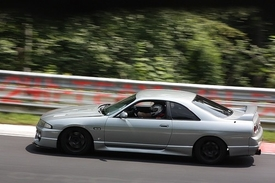

>>> Output image: images_with_boxes/car.jpg
>>> Detected object: car -- with confidence level of 0.633


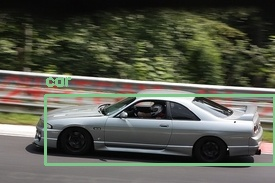


Input image: images/apple.jpg


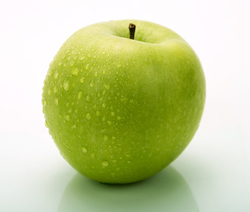

>>> Output image: images_with_boxes/apple.jpg
>>> Detected object: apple -- with confidence level of 0.572


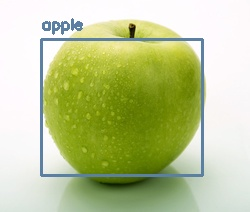


Input image: images/oranges.jpg


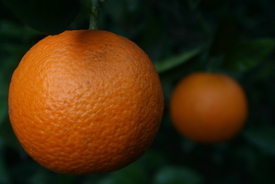

>>> Output image: images_with_boxes/oranges.jpg
>>> Detected object: orange -- with confidence level of 0.619
>>> Detected object: orange -- with confidence level of 0.556


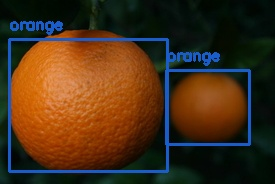


Input image: images/fruits.jpg


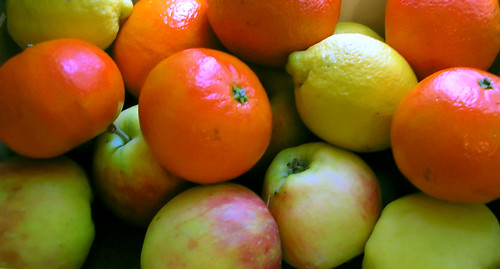

>>> Output image: images_with_boxes/fruits.jpg
>>> Detected object: apple -- with confidence level of 0.582
>>> Detected object: orange -- with confidence level of 0.535
>>> Detected object: orange -- with confidence level of 0.515


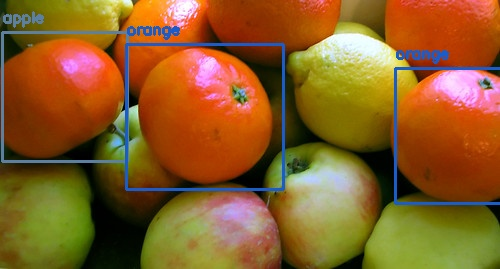

In [4]:
# Some example images
image_files = [
    'car.jpg',
    'apple.jpg',
    'oranges.jpg',
    'fruits.jpg'
]

for image_file in image_files:
    print(f"\nInput image: images/{image_file}")
    display(Image(filename=f"images/{image_file}"))
    detect_and_draw_box(image_file)

## Changing the confidence level

Looks like the object detection went fairly well. However, the **model failed to detect** several fruits and **misclassified** an orange as an apple in the last case. 

One possibility is that the model **did** detect the other fruits but with a confidence level lower than 0.5. 

Let's see the results as we're using different confidence level values:


Confidence level = 0.5
>>> Output image: images_with_boxes/fruits.jpg
>>> Detected object: apple -- with confidence level of 0.582
>>> Detected object: orange -- with confidence level of 0.535
>>> Detected object: orange -- with confidence level of 0.515


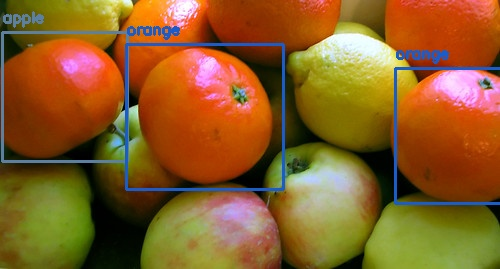


Confidence level = 0.4
>>> Output image: images_with_boxes/fruits.jpg
>>> Detected object: apple -- with confidence level of 0.582
>>> Detected object: orange -- with confidence level of 0.535
>>> Detected object: orange -- with confidence level of 0.515


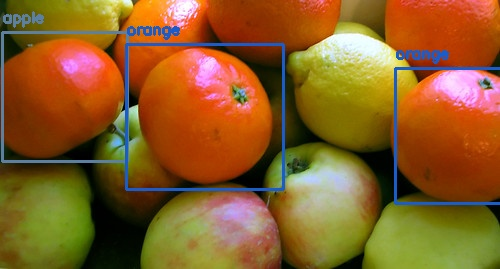


Confidence level = 0.3
>>> Output image: images_with_boxes/fruits.jpg
>>> Detected object: apple -- with confidence level of 0.582
>>> Detected object: orange -- with confidence level of 0.535
>>> Detected object: orange -- with confidence level of 0.515
>>> Detected object: apple -- with confidence level of 0.348
>>> Detected object: orange -- with confidence level of 0.329
>>> Detected object: apple -- with confidence level of 0.312


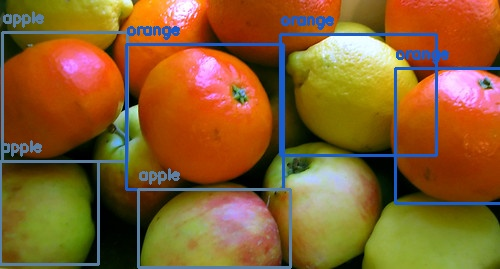


Confidence level = 0.2
>>> Output image: images_with_boxes/fruits.jpg
>>> Detected object: apple -- with confidence level of 0.582
>>> Detected object: orange -- with confidence level of 0.535
>>> Detected object: orange -- with confidence level of 0.515
>>> Detected object: apple -- with confidence level of 0.348
>>> Detected object: orange -- with confidence level of 0.329
>>> Detected object: apple -- with confidence level of 0.312
>>> Detected object: orange -- with confidence level of 0.280
>>> Detected object: orange -- with confidence level of 0.275
>>> Detected object: apple -- with confidence level of 0.274
>>> Detected object: orange -- with confidence level of 0.214


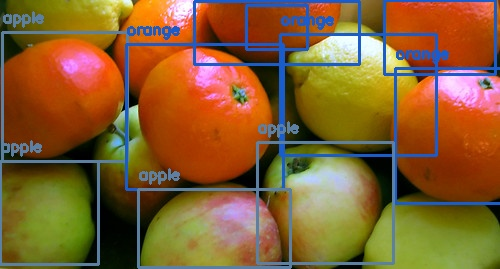


Confidence level = 0.1
>>> Output image: images_with_boxes/fruits.jpg
>>> Detected object: apple -- with confidence level of 0.582
>>> Detected object: orange -- with confidence level of 0.535
>>> Detected object: orange -- with confidence level of 0.515
>>> Detected object: apple -- with confidence level of 0.348
>>> Detected object: orange -- with confidence level of 0.329
>>> Detected object: apple -- with confidence level of 0.312
>>> Detected object: orange -- with confidence level of 0.280
>>> Detected object: orange -- with confidence level of 0.275
>>> Detected object: apple -- with confidence level of 0.274
>>> Detected object: orange -- with confidence level of 0.214


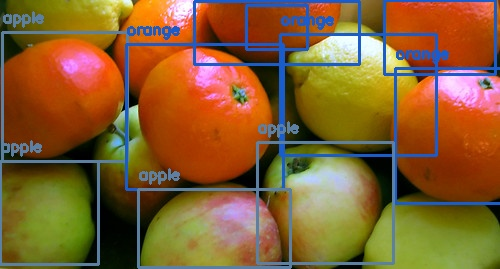

In [5]:
some_confindences = [0.5, 0.4, 0.3, 0.2,0.1]
for c in some_confindences:
    print(f"\nConfidence level = {c}")
    detect_and_draw_box("fruits.jpg", confidence=c)

By lowering the confidence level the model successfully detects most of the fruits. However, in order to correctly detect the objects present, we had to  set the confidence level really low. 

In general, we should be careful when decreasing or increasing these kinds of parameters, as changing them might yield undesired results.

As for this concrete example when an orange was misclassified as an apple, it serves as a reminder that these models are not perfect and this should be considered when using them for tasks in production.

## 2. Deploying the model on a server using fastAPI


Fist, let's also create a directory to store the images that are uploaded by a client to the server during the client-server interaction:

In [6]:
dir_name = "images_uploaded"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

Let's place the model on the server:

In [7]:
# Createan interacting instance of the FastAPI class 
app = FastAPI(title='Deploying a ML Model with FastAPI')

# List available models using Enum for convenience. This is useful when the options are pre-defined.
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"

# Use the GET method to work for the / endpoint.
@app.get("/")
def home():
    return "Congratulations! Your API is working as expected. Now head over to http://localhost:8000/docs."


# Use the POST method to handle all the logic necessary for the object detection.
# It requires the desired model, confidence level, and the image in which to perform object detection.
@app.post("/predict") 
def prediction(model: Model, confidence: float = Body(...), file: UploadFile = File(...)):

    # 1. VALIDATE INPUT FILE
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    
    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    # Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

    # Save it in "images_uploaded" folder within the server
    cv2.imwrite(f'images_uploaded/{filename}', image)
    
    
    # 3. RUN OBJECT DETECTION MODEL
    
    # Run object detection
    bbox, label, conf = cv.detect_common_objects(image, model=model,confidence=confidence)
    
    # Create image that includes bounding boxes and labels
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Save it in "images_with_boxes" folder within the server
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    
    
    # 4. STREAM THE RESPONSE BACK TO THE CLIENT
    
    # Open the saved image for reading in binary mode
    file_image = open(f'images_with_boxes/{filename}', mode="rb")
    
    # Return the image as a stream specifying media type
    return StreamingResponse(file_image, media_type="image/jpeg")

## 3. Spin up the server

**Note:** This causes the notebook to block (no cells/code can run) until we manually interrupt the kernel.

In [ ]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# Host depends on the setup you selected (docker or virtual env)
host = "0.0.0.0" if os.getenv("DOCKER-SETUP") else "127.0.0.1"

# Spin up the server!    
uvicorn.run(app, host=host, port=8000)

INFO:     Started server process [3256]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     172.17.0.1:64774 - "GET / HTTP/1.1" 200 OK
INFO:     172.17.0.1:64774 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     172.17.0.1:64782 - "GET /predict HTTP/1.1" 405 Method Not Allowed
INFO:     172.17.0.1:64782 - "GET /predict HTTP/1.1" 405 Method Not Allowed
INFO:     172.17.0.1:64790 - "GET /predict/ HTTP/1.1" 307 Temporary Redirect
INFO:     172.17.0.1:64790 - "GET /predict HTTP/1.1" 405 Method Not Allowed
INFO:     172.17.0.1:64816 - "GET / HTTP/1.1" 200 OK
INFO:     172.17.0.1:64822 - "GET /predict HTTP/1.1" 405 Method Not Allowed
INFO:     172.17.0.1:64888 - "GET /docs HTTP/1.1" 200 OK
INFO:     172.17.0.1:64888 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     172.17.0.1:64900 - "GET /docs HTTP/1.1" 200 OK
INFO:     172.17.0.1:64900 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     172.17.0.1:64920 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     172.17.0.1:64926 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK


## Comsume the model with fastAPI's built-in client.
The server is now running!
 
Head over to [http://localhost:8000/](http://localhost:8000/) to see it in action.

**Visit [http://localhost:8000/docs](http://localhost:8000/docs) to open fastAPI's built-in client.** 

**Try submitting an image** and see how our API is able to detect objects within it and return a new image containing the bounding boxes alongside the labels of the detected objects. 


## Consume your model from another client: using regular code (not UI)

----> Please open and run `client.ipynb` notebook